<a href="https://colab.research.google.com/github/RagnaChris/DeepLearning/blob/master/Notebooks/Image%20Classification/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST

Classification for MNIST Dataset

In [1]:
!pip install lightning torchinfo torchmetrics tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision as tv
import tqdm.auto as tqdm

from torch import nn, optim
from torchinfo import summary

In [3]:
def plot_predictions(model, images, labels):
  fig, axes = plt.subplots(2, 5, figsize=(10, 5))
  for i in range(10):
    image = images[i]
    label = labels[i]
    prediction = model(image).argmax()
    probability = model(image).softmax(dim=1)[0][prediction]
    axes[i // 5][i % 5].imshow(image.squeeze().numpy())
    axes[i // 5][i % 5].set_title(f"Label: {label}, Pred: {prediction}\nProb: {probability:.2f}",
                                  fontsize=12)
  plt.show()

##  MNIST Dataset

In [4]:
dataset = tv.datasets.MNIST(".", train=True, download=True, transform=tv.transforms.ToTensor())
train, val = data.random_split(dataset, [0.8, 0.2])
test = tv.datasets.MNIST(".", train=False, download=True, transform=tv.transforms.ToTensor())

train_loader = data.DataLoader(train, batch_size=128)
val_loader = data.DataLoader(val, batch_size=128)
test_loader = data.DataLoader(test, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 96160828.68it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106166252.26it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29267420.21it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20595166.24it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
image, label = next(iter(train_loader))
print(f"Shape: {image.shape}")

Shape: torch.Size([128, 1, 28, 28])


In [6]:
dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Model 0 - Linear

In [7]:
class LinearClassifier(L.LightningModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.seq = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = x.flatten(-1)
        x = self.seq(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("valid_loss", loss, on_step=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", loss)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [8]:
model0 = LinearClassifier()
trainer0 = L.Trainer(max_epochs=10)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [9]:
trainer0.fit(model0, train_loader, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type       | Params
------------------------------------
0 | fc1  | Linear     | 100 K 
1 | fc2  | Linear     | 1.3 K 
2 | seq  | Sequential | 101 K 
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name | Type       | Params
------------------------------------
0 | fc1  | Linear     | 100 K 
1 | fc2  | Linear     | 1.3 K 
2 | seq  | Sequential | 101 K 
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [10]:
trainer0.test(model0, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5810553431510925     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5810553431510925}]

In [11]:
model0.logger

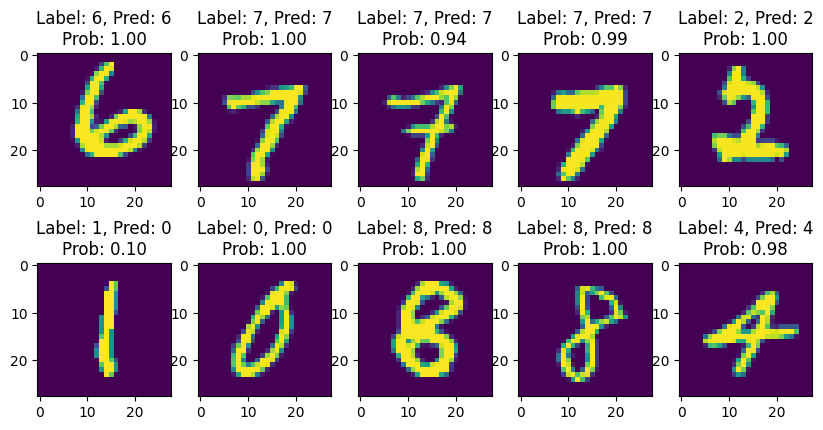

In [12]:
plot_predictions(model0, image, label)

## Model 1 - Convolution


In [13]:
class ConvClassifier(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc = nn.Linear(16*24*24, 10)
        self.seq = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.conv2,
            nn.ReLU()
        )

    def forward(self, x):
        x = self.seq(x)
        x = x.view(-1, 16*24*24)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("valid_loss", loss, on_step=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", loss, on_step=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [14]:
model1 = ConvClassifier()
trainer1 = L.Trainer(max_epochs=10)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [15]:
trainer1.fit(model1, train_loader, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Conv2d     | 80    
1 | conv2 | Conv2d     | 1.2 K 
2 | fc    | Linear     | 92.2 K
3 | seq   | Sequential | 1.2 K 
-------------------------------------
93.4 K    Trainable params
0         Non-trainable params
93.4 K    Total params
0.374     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Conv2d     | 80    
1 | conv2 | Conv2d     | 1.2 K 
2 | fc    | Linear     | 92.2 K
3 | seq   | Sequential | 1.2 K 
-------------------------------------
93.4 K    Trainable params
0         Non-trainable params
93.4 K    Total params
0.374     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [16]:
trainer1.test(model1, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.06430508941411972    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.06430508941411972}]

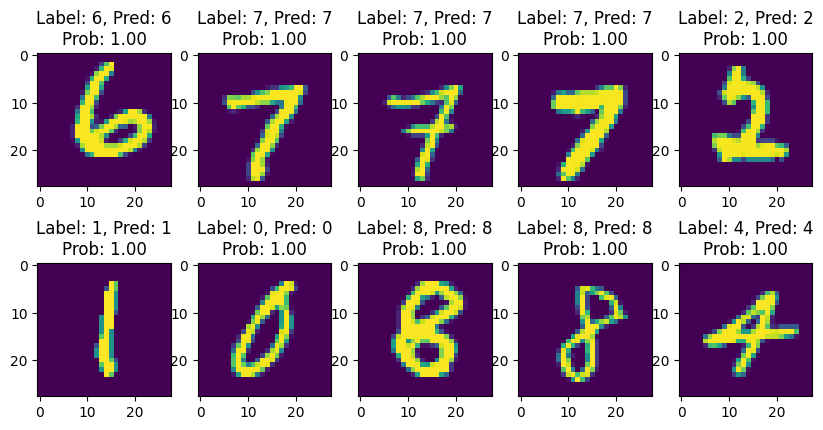

In [17]:
plot_predictions(model1, image, label)